In [ ]:
import cv2
import os
import numpy as np
import shutil
import random

# Global counter to track the unique ID across images
global_id_counter = 1

# Function to process multiple images, crop, segment, and save signatures
def process_signature_images(image_folder, save_folder):
    global global_id_counter
    
    # Ensure the save folder exists
    os.makedirs(save_folder, exist_ok=True)
    
    # Sort the images in numerical order
    image_files = sorted([f for f in os.listdir(image_folder) if f.endswith(('.jpg', '.jpeg', '.png'))],
                         key=lambda x: int(os.path.splitext(x)[0]))
    
    # Loop through all the sorted images in the folder
    for filename in image_files:
        # Construct full image path
        image_path = os.path.join(image_folder, filename)
        
        # Load and crop the image
        cropped_image = load_and_crop_image(image_path, filename)
        
        # Determine the number of rows based on the image
        if filename == '16.jpg':  # Adjust based on your last image's file name
            num_rows = 4  # The last image has 4 rows
        else:
            num_rows = 12  # Default to 12 rows for all other images
        
        # Segment the signatures and save them
        segment_signatures(cropped_image, save_folder, num_rows)

# Function to load the image and crop extra white space with better accuracy
def load_and_crop_image(image_path, filename):
    # Load the image
    image = cv2.imread(image_path)
    
    # Convert to grayscale for better contour and edge detection
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian blur to reduce noise and improve edge detection
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Use Canny edge detection to detect the edges of the grid
    edges = cv2.Canny(blurred, 50, 150)
    
    # Dilate the edges to make the grid lines more pronounced
    edges_dilated = cv2.dilate(edges, np.ones((5, 5), np.uint8), iterations=2)
    
    # Find contours on the dilated edge image
    contours, _ = cv2.findContours(edges_dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Find the largest contour, which should correspond to the grid containing the signatures
    largest_contour = max(contours, key=cv2.contourArea)
    
    # Get the bounding box of the largest contour
    x, y, w, h = cv2.boundingRect(largest_contour)
    
    # Crop the image using the bounding box coordinates
    cropped_image = image[y:y+h, x:x+w]
    
    # Further refine the crop to remove potential white space above and below
    cropped_image = refine_cropping(cropped_image)
    
    # Crop an additional 100 pixels from the top for all images
    if cropped_image.shape[0] > 100:
        cropped_image = cropped_image[100:, :]  # Remove the first 100 pixels from the top
    
    '''# Special case for '3.jpg': remove 200 pixels from the bottom
    if filename == '3.jpg' and cropped_image.shape[0] > 200:
        cropped_image = cropped_image[:-200, :]  # Remove 200 pixels from the bottom
    
    # Special case for '5.jpg': remove 100 pixels from the right and 100 pixels from the bottom
    if filename == '5.jpg':
        if cropped_image.shape[1] > 100:  # Ensure there's enough width to crop
            cropped_image = cropped_image[:, :-100]  # Remove 100 pixels from the right
        if cropped_image.shape[0] > 100:  # Ensure there's enough height to crop
            cropped_image = cropped_image[:-100, :]  # Remove 100 pixels from the bottom
    
    # Special case for '9.jpg': remove 100 pixels from the bottom
    if filename == '9.jpg' and cropped_image.shape[0] > 100:
        cropped_image = cropped_image[:-100, :]  # Remove 100 pixels from the bottom
    
    # Special case for '11.jpg': add 150 pixels of padding to the top
    if filename == '11.jpg':
        cropped_image = add_padding_to_top(cropped_image, 150)
    
    # Special case for '12.jpg': add 100 pixels of padding to the top
    if filename == '12.jpg':
        cropped_image = add_padding_to_top(cropped_image, 100)
    
    # Special case for '13.jpg': remove 100 pixels from the bottom
    if filename == '13.jpg' and cropped_image.shape[0] > 100:
        cropped_image = cropped_image[:-100, :]  # Remove 100 pixels from the bottom
    
    # Special case for '14.jpg': remove 150 pixels from the bottom
    if filename == '14.jpg' and cropped_image.shape[0] > 150:
        cropped_image = cropped_image[:-150, :]  # Remove 150 pixels from the bottom
    
    # Special case for '15.jpg': add 150 pixels of padding to the top
    if filename == '15.jpg':
        cropped_image = add_padding_to_top(cropped_image, 150)'''
    
    return cropped_image

# Function to add padding to the top of the image
def add_padding_to_top(image, padding_size):
    # Get the image dimensions
    height, width, channels = image.shape
    
    # Create a new blank image with the extra padding on top
    padding = np.full((padding_size, width, channels), 255, dtype=np.uint8)  # White padding
    
    # Stack the padding on top of the original image
    padded_image = np.vstack((padding, image))
    
    return padded_image

# Function to further refine the crop by removing extra white space
def refine_cropping(image):
    # Convert to grayscale for white space detection
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Threshold the image to get a binary image
    _, thresh = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)
    
    # Find contours again to remove any additional white space
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if contours:
        # Get the bounding box that covers all the detected signatures
        x, y, w, h = cv2.boundingRect(np.concatenate(contours))
        
        # Crop the image based on this bounding box
        refined_image = image[y:y+h, x:x+w]
        return refined_image
    else:
        # If no contours are found, return the original image
        return image

# Function to segment signatures and save them in folders based on the global ID counter
def segment_signatures(cropped_image, save_folder, num_rows):
    global global_id_counter  # Use the global ID counter across multiple images
    
    # Assume the image has num_rows rows (persons) and 5 columns (1 ID column + 4 signature columns)
    id_col_width_ratio = 0.085  # ID column width ratio
    signature_col_width_ratio = (1 - id_col_width_ratio) / 4  # 4 signature columns

    # Get image dimensions
    height, width, _ = cropped_image.shape
    
    # Calculate column widths
    id_col_width = int(width * id_col_width_ratio)
    signature_col_width = int(width * signature_col_width_ratio)
    
    row_height = height // num_rows

    # Loop through rows to process each person's signatures
    for i in range(num_rows):
        # Extract the ID from the first column (just process the image, not using OCR here)
        id_box = cropped_image[i * row_height: (i + 1) * row_height, 0: id_col_width]
        
        # Use the global_id_counter as the folder name (ID)
        person_id = global_id_counter
        
        # Create a folder for this person based on the global counter ID
        person_folder = os.path.join(save_folder, str(person_id))
        os.makedirs(person_folder, exist_ok=True)
        
        # Loop through signature columns and save each signature
        for j in range(4):  # 4 signature columns
            # Extract signature box
            signature = cropped_image[i * row_height: (i + 1) * row_height, 
                                      id_col_width + j * signature_col_width: id_col_width + (j + 1) * signature_col_width]
            
            # Convert the signature to grayscale before saving
            signature_gray = cv2.cvtColor(signature, cv2.COLOR_BGR2GRAY)
            
            # Save the signature image in grayscale in the person's folder
            signature_filename = os.path.join(person_folder, f'signature_{j+1}.jpg')
            cv2.imwrite(signature_filename, signature_gray)

            # Print the path to verify saving
            print(f"Saved: {signature_filename}")

        # Increment the global ID counter after processing each row (person)
        global_id_counter += 1

# Define paths
image_folder = '/Users/moonishaider/Desktop/FAST/Semester 9/Generative Ai/Assignments/Assignment1/Data'  # Folder where all your images are located
save_folder = '/Users/moonishaider/Desktop/FAST/Semester 9/Generative Ai/Assignments/Assignment1/Saved'  # Folder where segmented signatures will be saved

# Process all the images
process_signature_images(image_folder, save_folder)

In [ ]:
import shutil
import random


def train_test_split_images(source_dir, dest_dir, train_ratio=0.75):
    # Define paths for the train and test directories
    train_dir = os.path.join(dest_dir, "Train")
    test_dir = os.path.join(dest_dir, "Test")
    
    # Create the directories if they do not exist
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)
    
    # Get all the folders (IDs)
    id_folders = [f for f in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, f))]
    
    # Loop through each ID folder
    for id_folder in id_folders:
        folder_path = os.path.join(source_dir, id_folder)
        images = [img for img in os.listdir(folder_path) if img.endswith(('.jpg', '.jpeg', '.png'))]
        
        # Ensure we have exactly 4 images per folder
        if len(images) != 4:
            print(f"Skipping folder {id_folder} as it does not contain 4 images.")
            continue
        
        # Randomly shuffle the images (optional, can be skipped if you want to keep the order)
        random.shuffle(images)
        
        # Split the images into training (3 images) and testing (1 image)
        train_images = images[:3]
        test_image = images[3:]
        
        # Create ID subfolders in Train and Test directories
        train_id_folder = os.path.join(train_dir, id_folder)
        test_id_folder = os.path.join(test_dir, id_folder)
        
        os.makedirs(train_id_folder, exist_ok=True)
        os.makedirs(test_id_folder, exist_ok=True)
        
        # Copy training images
        for train_image in train_images:
            source_image_path = os.path.join(folder_path, train_image)
            dest_image_path = os.path.join(train_id_folder, train_image)
            shutil.copy(source_image_path, dest_image_path)
        
        # Copy testing image
        for test_img in test_image:
            source_image_path = os.path.join(folder_path, test_img)
            dest_image_path = os.path.join(test_id_folder, test_img)
            shutil.copy(source_image_path, dest_image_path)
        
        print(f"Processed folder {id_folder}: 3 images for training, 1 image for testing.")

# Define the source directory where the original 184 folders are located
source_dir = "/Users/moonishaider/Desktop/FAST/Semester 9/Generative Ai/Assignments/Assignment1/Saved"

# Define the destination directory where Train and Test folders will be saved
dest_dir = "/Users/moonishaider/Desktop/FAST/Semester 9/Generative Ai/Assignments/Assignment1"

# Perform the train-test split
train_test_split_images(source_dir, dest_dir)

In [7]:
######## Best code yet with 57% test acc and 90% + train accuracy


import tensorflow as tf
from tensorflow.keras import layers, models, callbacks , regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Paths to training and testing data
train_dir = "/Users/moonishaider/Desktop/FAST/Semester 9/Generative Ai/Assignments/Assignment1/Train"
test_dir = "/Users/moonishaider/Desktop/FAST/Semester 9/Generative Ai/Assignments/Assignment1/Test"

# Image dimensions (smaller size)
img_height, img_width = 64, 64  # Reduced image size
batch_size = 32  # Adjust based on your available memory

# Data Augmentation and Preprocessing for Train and Test
train_datagen = ImageDataGenerator(
    rescale=1./255,            # Normalize pixel values to [0, 1]
    rotation_range=5,          # Slight random rotation to simulate different orientations
    width_shift_range=0.05,    # Slight horizontal shift
    height_shift_range=0.05,   # Slight vertical shift
    shear_range=0.05,          # Slight shear transformation
    zoom_range=0.05,           # Slight zoom to simulate variability
    fill_mode='nearest'        # Fill missing pixels after transformations
)

test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale the test data

# Load training and testing datasets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'   # Assuming multiple classes (one per person)
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Define the CNN architecture with Batch Normalization and three convolutional layers
model = models.Sequential([
    # First Conv block
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.BatchNormalization(),  # Add batch normalization after each convolutional layer
    layers.MaxPooling2D((2, 2)),

    # Second Conv block
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Flatten the output and fully connected layers
    layers.Flatten(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),  # Add dropout to reduce overfitting
    layers.Dense(len(train_generator.class_indices), activation='softmax')  # Output layer with softmax
])

# Compile the CNN model with a reduced learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),  # Reduced learning rate
              loss='categorical_crossentropy',  # For multi-class classification
              metrics=['accuracy'])

# Early stopping callback
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Model summary
model.summary()

# Train the model with early stopping
epochs = 150  # Number of epochs to train
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    callbacks=[early_stopping]  # Adding early stopping
)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

Found 699 images belonging to 184 classes.
Found 331 images belonging to 184 classes.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 62, 62, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 29, 29, 64)        256       
 chNormalization)                                                
                                                        

21/21 [==============================] - 10s 494ms/step - loss: 2.6786 - accuracy: 0.4528 - val_loss: 2.4498 - val_accuracy: 0.6438
Epoch 44/150
21/21 [==============================] - 9s 421ms/step - loss: 2.6449 - accuracy: 0.4933 - val_loss: 2.3694 - val_accuracy: 0.6531
Epoch 45/150
21/21 [==============================] - 10s 482ms/step - loss: 2.4175 - accuracy: 0.5217 - val_loss: 2.3835 - val_accuracy: 0.6750
Epoch 46/150
21/21 [==============================] - 10s 487ms/step - loss: 2.4973 - accuracy: 0.5097 - val_loss: 2.3638 - val_accuracy: 0.6500
Epoch 47/150
21/21 [==============================] - 10s 478ms/step - loss: 2.4613 - accuracy: 0.5247 - val_loss: 2.3650 - val_accuracy: 0.6750
Epoch 48/150
21/21 [==============================] - 10s 481ms/step - loss: 2.4885 - accuracy: 0.5172 - val_loss: 2.3339 - val_accuracy: 0.6687
Epoch 49/150
21/21 [==============================] - 10s 469ms/step - loss: 2.3899 - accuracy: 0.5277 - val_loss: 2.2357 - val_accuracy: 0.6875

Epoch 100/150
21/21 [==============================] - 8s 391ms/step - loss: 1.1881 - accuracy: 0.8199 - val_loss: 1.6398 - val_accuracy: 0.7781
Epoch 101/150
21/21 [==============================] - 8s 399ms/step - loss: 1.2081 - accuracy: 0.8276 - val_loss: 1.6205 - val_accuracy: 0.7906
Epoch 102/150
21/21 [==============================] - 10s 484ms/step - loss: 1.1255 - accuracy: 0.8381 - val_loss: 1.7569 - val_accuracy: 0.7688
Epoch 103/150
21/21 [==============================] - 10s 465ms/step - loss: 1.2343 - accuracy: 0.8006 - val_loss: 1.7021 - val_accuracy: 0.7844
Epoch 104/150
21/21 [==============================] - 10s 481ms/step - loss: 1.1739 - accuracy: 0.8306 - val_loss: 1.6752 - val_accuracy: 0.7812
Epoch 105/150
21/21 [==============================] - 10s 465ms/step - loss: 1.1918 - accuracy: 0.8231 - val_loss: 1.6474 - val_accuracy: 0.7844
Epoch 106/150
21/21 [==============================] - 11s 526ms/step - loss: 1.1888 - accuracy: 0.8141 - val_loss: 1.6568 - v

In [8]:
model.save('/Users/moonishaider/Desktop/FAST/Semester 9/Generative Ai/Assignments/Assignment1/saved_model.h5')

/Users/moonishaider/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [10]:
####.      run the code without running the model basicaly saving the model


# Required imports
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

# Define the paths to your data
train_dir = "/Users/moonishaider/Desktop/FAST/Semester 9/Generative Ai/Assignments/Assignment1/Train"
test_dir = "/Users/moonishaider/Desktop/FAST/Semester 9/Generative Ai/Assignments/Assignment1/Test"

# Image dimensions and batch size
img_height, img_width = 64, 64
batch_size = 32

# Data Augmentation and Preprocessing for Train and Test
test_datagen = ImageDataGenerator(rescale=1./255)

# Recreate the test generator (necessary after kernel reset)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Load the saved model
model = load_model('/Users/moonishaider/Desktop/FAST/Semester 9/Generative Ai/Assignments/Assignment1/saved_model.h5')

# Use the loaded model for evaluation or inference
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

Found 331 images belonging to 184 classes.


11/11 [==============================] - 3s 238ms/step - loss: 1.5719 - accuracy: 0.7976
Test Accuracy: 0.7976


In [36]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

# Generate predictions
y_pred = model.predict(test_generator)
y_pred_labels = np.argmax(y_pred, axis=1)

# Get the true labels from the generator
y_true = test_generator.classes

# Get class labels mapping
class_labels = list(test_generator.class_indices.keys())

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred_labels, target_names=class_labels))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred_labels))

# Calculate Precision, Recall, F-Measure, and Accuracy
classification_metrics = classification_report(y_true, y_pred_labels, target_names=class_labels, output_dict=True)
precision = classification_metrics['weighted avg']['precision']
recall = classification_metrics['weighted avg']['recall']
f1_score = classification_metrics['weighted avg']['f1-score']
accuracy = test_acc  # Accuracy from model evaluation

# Print the calculated metrics
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F-Measure: {f1_score:.4f}")
print(f"Accuracy: {accuracy:.4f}")

11/11 [==============================] - 3s 231ms/step - loss: 1.5719 - accuracy: 0.7976
Test Accuracy: 0.7976
11/11 [==============================] - 2s 202ms/step
Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
          10       0.00      0.00      0.00         2
         100       0.00      0.00      0.00         2
         101       0.00      0.00      0.00         2
         102       0.00      0.00      0.00         1
         103       0.00      0.00      0.00         1
         104       0.00      0.00      0.00         2
         105       0.00      0.00      0.00         1
         106       0.00      0.00      0.00         2
         107       0.00      0.00      0.00         2
         108       0.00      0.00      0.00         1
         109       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         2
         110       0.00      0.00      0.00         2


/Users/moonishaider/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/moonishaider/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/moonishaider/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

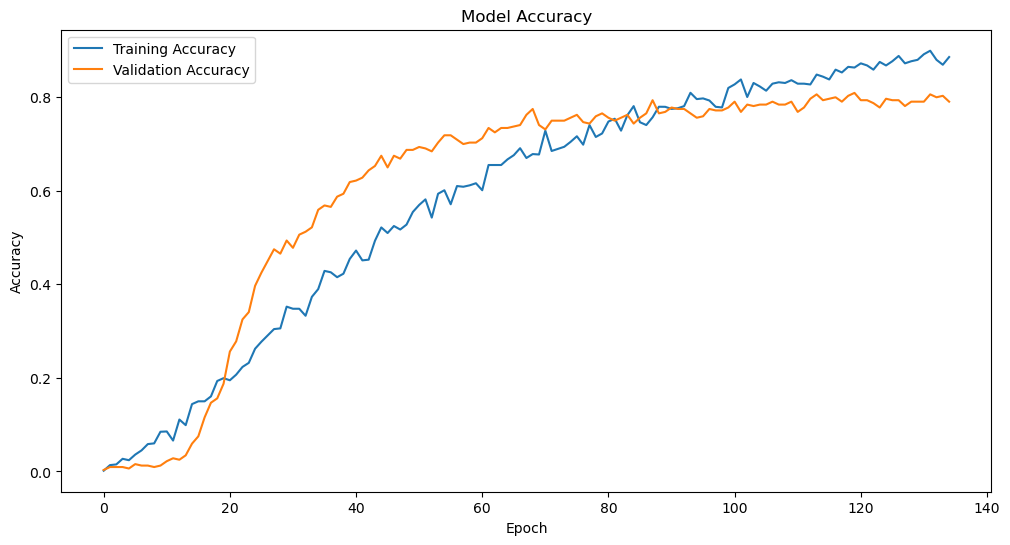

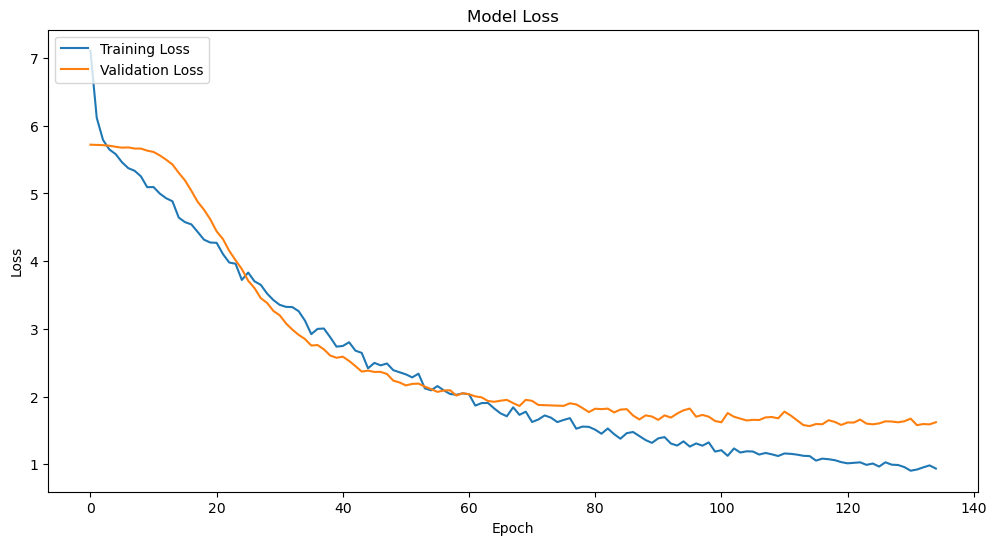

In [11]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

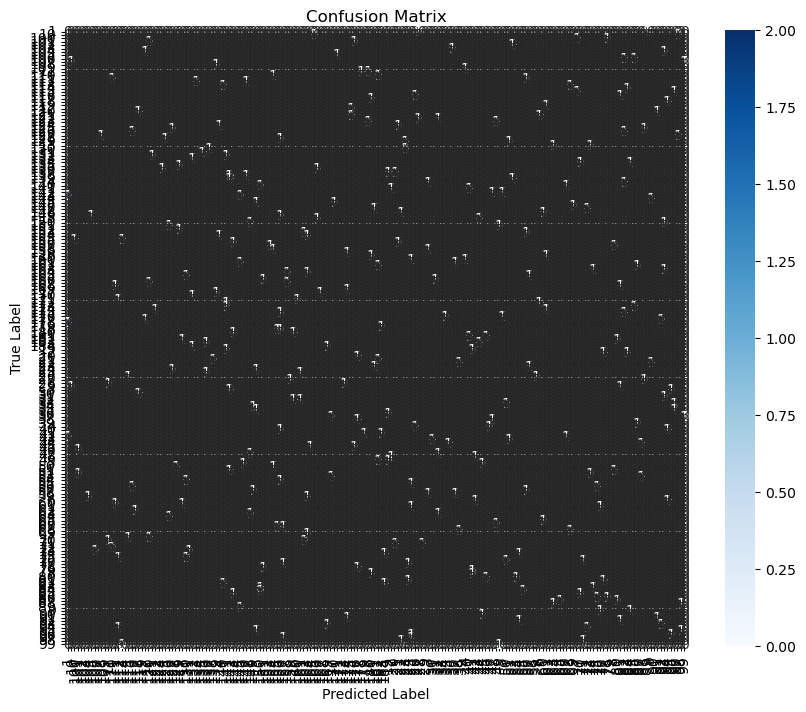

In [12]:
import seaborn as sns

# Confusion matrix visualization
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [40]:
import numpy as np
import cv2
import os
from skimage.feature import hog
from skimage import color
from tensorflow.keras import models, layers
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# Paths
train_dir = "/Users/moonishaider/Desktop/FAST/Semester 9/Generative Ai/Assignments/Assignment1/Train"
test_dir = "/Users/moonishaider/Desktop/FAST/Semester 9/Generative Ai/Assignments/Assignment1/Test"

# Load dataset from directory
def load_images_from_folder(folder):
    images = []
    labels = []
    for label in os.listdir(folder):
        class_path = os.path.join(folder, label)
        if os.path.isdir(class_path):
            for file in os.listdir(class_path):
                img_path = os.path.join(class_path, file)
                img = cv2.imread(img_path)
                if img is not None:
                    img_resized = cv2.resize(img, (64, 64))  # Resize to 64x64
                    images.append(img_resized)
                    labels.append(label)
    return np.array(images), np.array(labels)

# Load training and testing images
X_train, y_train = load_images_from_folder(train_dir)
X_test, y_test = load_images_from_folder(test_dir)

# Encode labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Convert labels to categorical
y_train_cat = to_categorical(y_train_encoded)
y_test_cat = to_categorical(y_test_encoded)

from skimage.feature import hog
from skimage import color

def extract_hog_features(images):
    hog_features = []
    for img in images:
        # Convert image to grayscale
        gray_img = color.rgb2gray(img)  # Ensure conversion to grayscale
        # Extract HOG features using correct parameter
        hog_feat = hog(gray_img, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False, channel_axis=None)
        hog_features.append(hog_feat)
    return np.array(hog_features)

# Extract HOG features for training and testing datasets
hog_train_features = extract_hog_features(X_train)
hog_test_features = extract_hog_features(X_test)

import cv2
import numpy as np

def extract_sift_features(images, max_descriptors=128):
    sift = cv2.SIFT_create()
    sift_features = []
    
    for img in images:
        # Convert to grayscale
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # Extract SIFT keypoints and descriptors
        keypoints, descriptors = sift.detectAndCompute(gray_img, None)
        
        # If descriptors are found, pad or truncate to the fixed size
        if descriptors is not None:
            # Flatten the descriptors
            descriptors = descriptors.flatten()
            if len(descriptors) > max_descriptors:
                descriptors = descriptors[:max_descriptors]  # Truncate to the first `max_descriptors`
            elif len(descriptors) < max_descriptors:
                descriptors = np.pad(descriptors, (0, max_descriptors - len(descriptors)), 'constant')  # Pad with zeros
        else:
            # If no descriptors, use a zero vector
            descriptors = np.zeros(max_descriptors)
        
        sift_features.append(descriptors)
    
    return np.array(sift_features)

# Example usage:
sift_train_features = extract_sift_features(X_train)
sift_test_features = extract_sift_features(X_test)

# Ensure that HOG and SIFT features have the same length for each image
hog_train_features = hog_train_features.reshape(hog_train_features.shape[0], -1)
hog_test_features = hog_test_features.reshape(hog_test_features.shape[0], -1)

# Building ANN for HOG and SIFT Features
def build_ann_model(input_dim):
    model = models.Sequential([
        layers.Dense(512, activation='relu', input_dim=input_dim),
        layers.Dense(256, activation='relu'),
        layers.Dense(len(np.unique(y_train_encoded)), activation='softmax')  # Output layer
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# HOG-ANN Model
hog_ann_model = build_ann_model(hog_train_features.shape[1])
history_hog = hog_ann_model.fit(hog_train_features, y_train_cat, epochs=100, validation_data=(hog_test_features, y_test_cat))

# SIFT-ANN Model
sift_ann_model = build_ann_model(sift_train_features.shape[1])
history_sift = sift_ann_model.fit(sift_train_features, y_train_cat, epochs=100, validation_data=(sift_test_features, y_test_cat))

# Evaluate models
print("Evaluating HOG-ANN Model")
hog_test_loss, hog_test_acc = hog_ann_model.evaluate(hog_test_features, y_test_cat)
print(f"HOG-ANN Test Accuracy: {hog_test_acc:.4f}")

print("Evaluating SIFT-ANN Model")
sift_test_loss, sift_test_acc = sift_ann_model.evaluate(sift_test_features, y_test_cat)
print(f"SIFT-ANN Test Accuracy: {sift_test_acc:.4f}")

# Classification Reports and Confusion Matrices
hog_pred = np.argmax(hog_ann_model.predict(hog_test_features), axis=1)
sift_pred = np.argmax(sift_ann_model.predict(sift_test_features), axis=1)

print("Classification Report for HOG-ANN:")
print(classification_report(y_test_encoded, hog_pred, target_names=le.classes_))

print("Confusion Matrix for HOG-ANN:")
print(confusion_matrix(y_test_encoded, hog_pred))

print("Classification Report for SIFT-ANN:")
print(classification_report(y_test_encoded, sift_pred, target_names=le.classes_))

print("Confusion Matrix for SIFT-ANN:")
print(confusion_matrix(y_test_encoded, sift_pred))

Epoch 1/100
22/22 [==============================] - 0s 9ms/step - loss: 5.2984 - accuracy: 0.0043 - val_loss: 5.1897 - val_accuracy: 0.0121
Epoch 2/100
22/22 [==============================] - 0s 5ms/step - loss: 5.1837 - accuracy: 0.0057 - val_loss: 5.1189 - val_accuracy: 0.0363
Epoch 3/100
22/22 [==============================] - 0s 5ms/step - loss: 5.0780 - accuracy: 0.0272 - val_loss: 5.0013 - val_accuracy: 0.0181
Epoch 4/100
22/22 [==============================] - 0s 5ms/step - loss: 4.9094 - accuracy: 0.0429 - val_loss: 4.8225 - val_accuracy: 0.0634
Epoch 5/100
22/22 [==============================] - 0s 5ms/step - loss: 4.6159 - accuracy: 0.0701 - val_loss: 4.4746 - val_accuracy: 0.1511
Epoch 6/100
22/22 [==============================] - 0s 5ms/step - loss: 4.2155 - accuracy: 0.1345 - val_loss: 4.2193 - val_accuracy: 0.2024
Epoch 7/100
22/22 [==============================] - 0s 5ms/step - loss: 3.7901 - accuracy: 0.2489 - val_loss: 3.8342 - val_accuracy: 0.2568
Epoch 8/100
2

Epoch 59/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0066 - accuracy: 1.0000 - val_loss: 1.5266 - val_accuracy: 0.7462
Epoch 60/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0064 - accuracy: 1.0000 - val_loss: 1.5242 - val_accuracy: 0.7432
Epoch 61/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0062 - accuracy: 1.0000 - val_loss: 1.5274 - val_accuracy: 0.7432
Epoch 62/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 1.5273 - val_accuracy: 0.7462
Epoch 63/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0057 - accuracy: 1.0000 - val_loss: 1.5321 - val_accuracy: 0.7462
Epoch 64/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0055 - accuracy: 1.0000 - val_loss: 1.5377 - val_accuracy: 0.7462
Epoch 65/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.5341 - val_accuracy: 0.7462
Epoch 

Epoch 17/100
22/22 [==============================] - 0s 3ms/step - loss: 0.2102 - accuracy: 0.9642 - val_loss: 5.6807 - val_accuracy: 0.5468
Epoch 18/100
22/22 [==============================] - 0s 3ms/step - loss: 0.2086 - accuracy: 0.9642 - val_loss: 5.7244 - val_accuracy: 0.5468
Epoch 19/100
22/22 [==============================] - 0s 3ms/step - loss: 0.2069 - accuracy: 0.9642 - val_loss: 5.7533 - val_accuracy: 0.5468
Epoch 20/100
22/22 [==============================] - 0s 3ms/step - loss: 0.2047 - accuracy: 0.9642 - val_loss: 5.7815 - val_accuracy: 0.5468
Epoch 21/100
22/22 [==============================] - 0s 3ms/step - loss: 0.2012 - accuracy: 0.9642 - val_loss: 5.8135 - val_accuracy: 0.5468
Epoch 22/100
22/22 [==============================] - 0s 3ms/step - loss: 0.1946 - accuracy: 0.9642 - val_loss: 5.8462 - val_accuracy: 0.5468
Epoch 23/100
22/22 [==============================] - 0s 3ms/step - loss: 0.1845 - accuracy: 0.9642 - val_loss: 5.8499 - val_accuracy: 0.5468
Epoch 

Epoch 75/100
22/22 [==============================] - 0s 4ms/step - loss: 0.1205 - accuracy: 0.9642 - val_loss: 6.6297 - val_accuracy: 0.5438
Epoch 76/100
22/22 [==============================] - 0s 3ms/step - loss: 0.1205 - accuracy: 0.9642 - val_loss: 6.6371 - val_accuracy: 0.5438
Epoch 77/100
22/22 [==============================] - 0s 3ms/step - loss: 0.1203 - accuracy: 0.9642 - val_loss: 6.6487 - val_accuracy: 0.5438
Epoch 78/100
22/22 [==============================] - 0s 3ms/step - loss: 0.1204 - accuracy: 0.9642 - val_loss: 6.6607 - val_accuracy: 0.5438
Epoch 79/100
22/22 [==============================] - 0s 3ms/step - loss: 0.1206 - accuracy: 0.9642 - val_loss: 6.6659 - val_accuracy: 0.5438
Epoch 80/100
22/22 [==============================] - 0s 3ms/step - loss: 0.1205 - accuracy: 0.9642 - val_loss: 6.6725 - val_accuracy: 0.5438
Epoch 81/100
22/22 [==============================] - 0s 3ms/step - loss: 0.1205 - accuracy: 0.9642 - val_loss: 6.6832 - val_accuracy: 0.5438
Epoch 

/Users/moonishaider/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/moonishaider/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/moonishaider/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [24]:
# Evaluate CNN
test_loss_cnn, test_acc_cnn = model.evaluate(test_generator)
print(f"CNN Test Accuracy: {test_acc_cnn:.4f}")

from tensorflow.keras.utils import to_categorical

# Convert test_labels to one-hot encoding
test_labels_onehot = to_categorical(test_labels, num_classes=len(train_generator.class_indices))

# Evaluate HOG-ANN
test_loss_hog, test_acc_hog = model_hog.evaluate(hog_test_features, test_labels_onehot)
print(f"HOG-ANN Test Accuracy: {test_acc_hog:.4f}")

# Evaluate SIFT-ANN
test_loss_sift, test_acc_sift = model_sift.evaluate(sift_test_features, test_labels_onehot)
print(f"SIFT-ANN Test Accuracy: {test_acc_sift:.4f}")

11/11 [==============================] - 2s 133ms/step - loss: 1.5719 - accuracy: 0.7976
CNN Test Accuracy: 0.7976
11/11 [==============================] - 0s 1ms/step - loss: 23.6504 - accuracy: 0.0121
HOG-ANN Test Accuracy: 0.0121
11/11 [==============================] - 0s 1ms/step - loss: 6.0351 - accuracy: 0.0000e+00
SIFT-ANN Test Accuracy: 0.0000


In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
import numpy as np
import pandas as pd

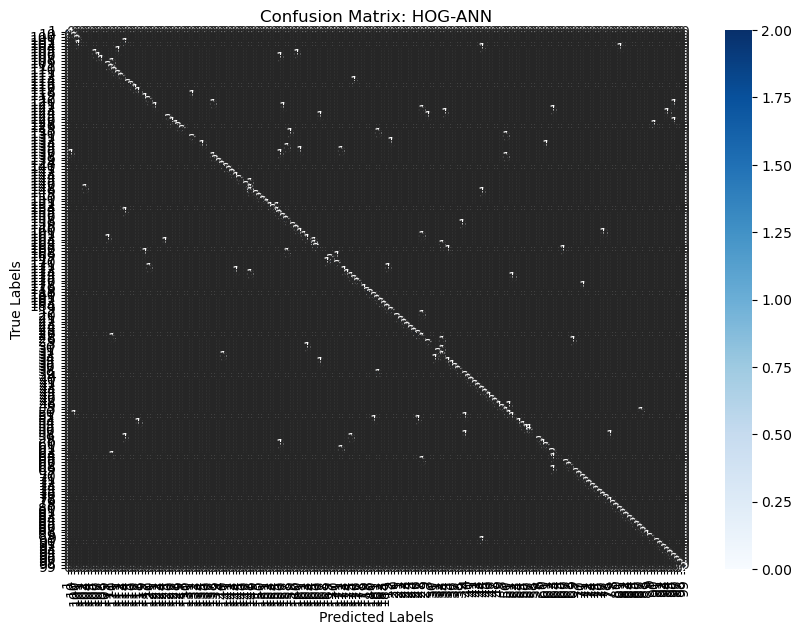

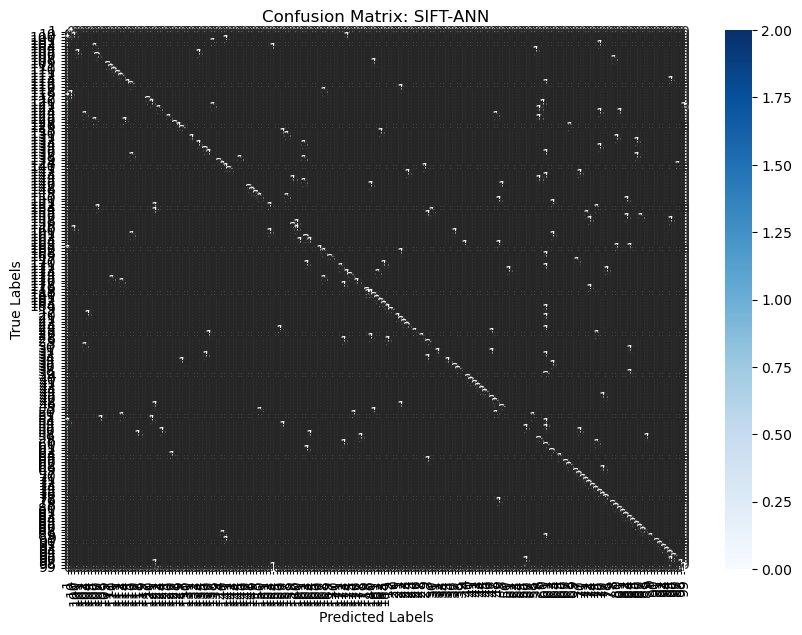

NameError: name 'cnn_model' is not defined

In [38]:
# Function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix: {title}')
    plt.show()

# Plot Confusion Matrix for HOG-ANN
plot_confusion_matrix(y_test_encoded, hog_pred, title="HOG-ANN")

# Plot Confusion Matrix for SIFT-ANN
plot_confusion_matrix(y_test_encoded, sift_pred, title="SIFT-ANN")

# Plot Confusion Matrix for CNN
cnn_pred = np.argmax(cnn_model.predict(X_test), axis=1)  # Assuming you have a trained CNN
plot_confusion_matrix(y_test_encoded, cnn_pred, title="CNN")

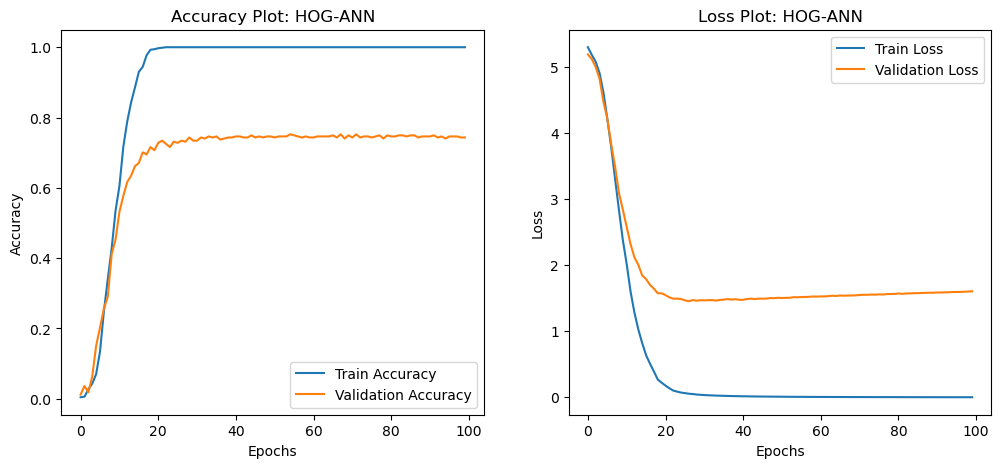

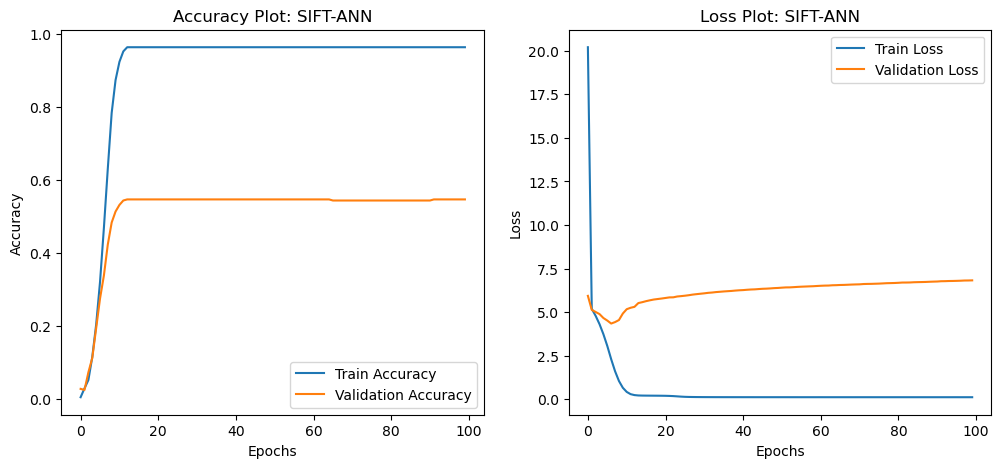

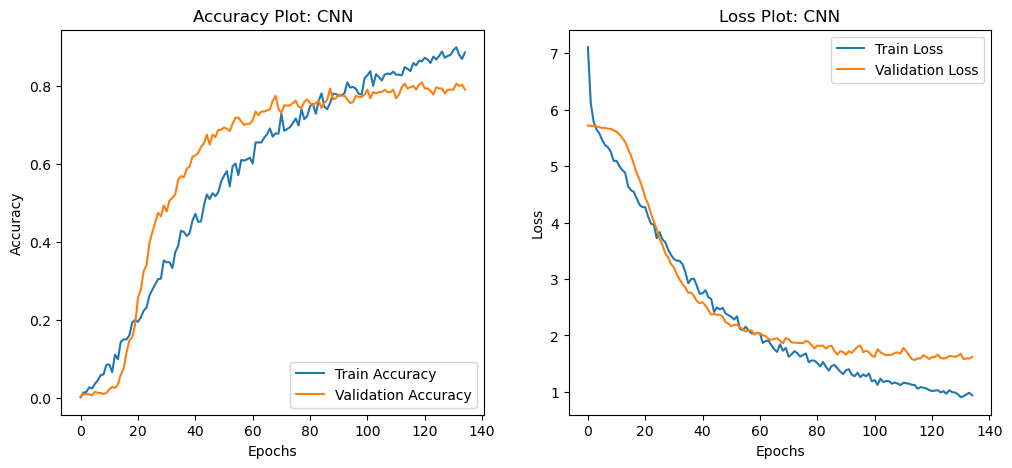

In [41]:
# Function to plot accuracy and loss curves
def plot_accuracy_loss(history, title):
    # Plot accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'Accuracy Plot: {title}')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title(f'Loss Plot: {title}')
    
    plt.show()

# Plot accuracy and loss for HOG-ANN
plot_accuracy_loss(history_hog, title="HOG-ANN")

# Plot accuracy and loss for SIFT-ANN
plot_accuracy_loss(history_sift, title="SIFT-ANN")

# Plot accuracy and loss for CNN
plot_accuracy_loss(history, title="CNN")

11/11 [==============================] - 0s 2ms/step


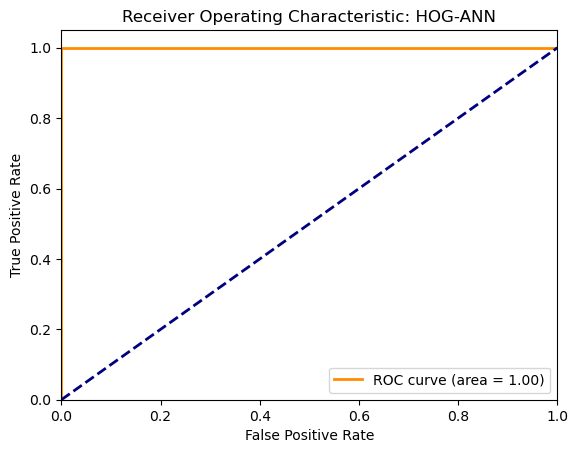

11/11 [==============================] - 0s 1ms/step


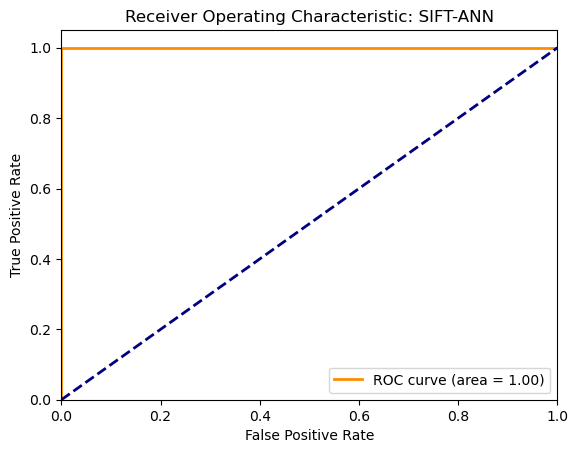

11/11 [==============================] - 0s 19ms/step


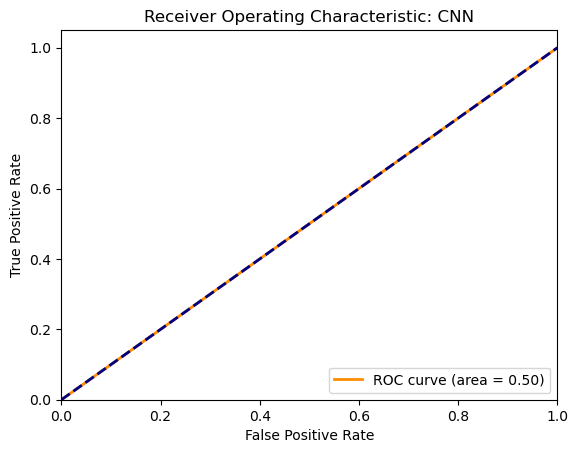

In [42]:
# Function to plot ROC curve
def plot_roc_curve(y_true, y_pred_proba, title):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba, pos_label=1)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic: {title}')
    plt.legend(loc='lower right')
    plt.show()

# For HOG-ANN
hog_pred_proba = hog_ann_model.predict(hog_test_features)
plot_roc_curve(y_test_encoded, hog_pred_proba[:, 1], title="HOG-ANN")

# For SIFT-ANN
sift_pred_proba = sift_ann_model.predict(sift_test_features)
plot_roc_curve(y_test_encoded, sift_pred_proba[:, 1], title="SIFT-ANN")

# For CNN
cnn_pred_proba = model.predict(X_test)  # Assuming X_test is the test dataset for CNN
plot_roc_curve(y_test_encoded, cnn_pred_proba[:, 1], title="CNN")

In [ ]:
input_dir = '/Users/moonishaider/Desktop/FAST/Semester 9/Generative Ai/Assignments/Assignment1/Data'  # Replace with the folder containing your 16 images
output_dir = '/Users/moonishaider/Desktop/FAST/Semester 9/Generative Ai/Assignments/Assignment1'  # Directory where segmented signatures will be saved
/Users/moonishaider/Desktop/FAST/Semester 9/Generative Ai/Assignments/Assignment1/Data
/Users/moonishaider/Desktop/FAST/Semester 9/Generative Ai/Assignments/Assignment1/Saved

In [ ]:
### code with high train acc and low test acc



import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Paths to training and testing data
train_dir = "/Users/moonishaider/Desktop/FAST/Semester 9/Generative Ai/Assignments/Assignment1/Train"
test_dir = "/Users/moonishaider/Desktop/FAST/Semester 9/Generative Ai/Assignments/Assignment1/Test"

# Image dimensions (smaller size)
img_height, img_width = 64, 64  # Reduced image size
batch_size = 32  # Adjust based on your available memory

# Data Augmentation and Preprocessing for Train and Test
train_datagen = ImageDataGenerator(
    rescale=1./255,            # Normalize pixel values to [0, 1]
    rotation_range=5,          # Slight random rotation to simulate different orientations
    width_shift_range=0.05,    # Slight horizontal shift
    height_shift_range=0.05,   # Slight vertical shift
    shear_range=0.05,          # Slight shear transformation
    zoom_range=0.05,           # Slight zoom to simulate variability
    fill_mode='nearest'        # Fill missing pixels after transformations
)

test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale the test data

# Load training and testing datasets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'   # Assuming multiple classes (one per person)
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Define the simpler CNN architecture
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),  # Add dropout to reduce overfitting
    layers.Dense(len(train_generator.class_indices), activation='softmax')  # Output layer with softmax
])

# Compile the CNN model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # For multi-class classification
              metrics=['accuracy'])

# Model summary
model.summary()

# Train the model
epochs = 500  # Number of epochs to train
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size
)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

In [ ]:
####code to run at night





import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Paths to training and testing data
train_dir = "/Users/moonishaider/Desktop/FAST/Semester 9/Generative Ai/Assignments/Assignment1/Train"
test_dir = "/Users/moonishaider/Desktop/FAST/Semester 9/Generative Ai/Assignments/Assignment1/Test"

# Image dimensions (smaller size)
img_height, img_width = 64, 64
batch_size = 32

# Data Augmentation and Preprocessing for Train and Test
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load training and testing datasets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Define the CNN architecture with increased complexity
model = models.Sequential([
    # First Conv block
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),  # Dropout to reduce overfitting

    # Second Conv block
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),

    # Third Conv block
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),

    # Fourth Conv block
    layers.Conv2D(512, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),

    # Flatten and Fully Connected layer
    layers.Flatten(),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),  # Increased neurons in Dense layer
    layers.Dropout(0.5),

    # Output layer
    layers.Dense(len(train_generator.class_indices), activation='softmax')
])

# Compile the CNN model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Keep the low learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Early stopping callback to stop training when the validation loss stops improving
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Model summary
model.summary()

# Train the model with early stopping
epochs = 1500
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    #callbacks=[early_stopping]
)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")